In [ ]:
# Running the Colab Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
#Calling the necessary Python libraries:
from plotly.offline import init_notebook_mode, iplot
from wordcloud import WordCloud
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly as py
from plotly import tools
from datetime import date
import pandas as pd
import numpy as np 
import seaborn as sns

In [2]:
Pos_Cash = pd.read_csv('C:\\Users\\kbc\Downloads\\home-credit-default-risk\\POS_CASH_balance.csv')
Pos_Cash.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit. This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample # of relative previous credits # of months in which we have some history observable for the previous credits) rows.

- MONTHS_BALANCE	Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at application - often it will be the same as -1 as many banks are not updating the information to Credit Bureau regularly )	time only relative to the application	Başvuru tarihine göre bakiye ayı (-1 değeri, daha yeni bakiye tarihine karşılık geliyor.)

CNT_INSTALMENT	Term of previous credit (can change over time)		Önceki kredinin süresi (zamanla değişebilir)

CNT_INSTALMENT_FUTURE	Installments left to pay on the previous credit		Önceki krediden kalan ödenmesi gereken taksitler

NAME_CONTRACT_STATUS	Contract status during the month		Ay boyunca sözleşme durumu

SK_DPD	DPD (days past due) during the month of previous credit		Önceki krediden vadesi  geçen günler

SK_DPD_DEF	DPD during the month with tolerance (debts with low loan amounts are ignored) of the previous credit		Bir önceki kredinin toleransla (düşük kredi miktarları olan borçlar dikkate alınmaz) vadesi geçen günler

In [3]:
# An useful function to analyse the dataframes

def summary(df, pred=None):
    obs = df.shape[0]
    Types = df.dtypes
    Counts = df.apply(lambda x: x.count())
    Min = df.min()
    Max = df.max()
    Uniques = df.apply(lambda x: x.unique().shape[0])
    Nulls = df.apply(lambda x: x.isnull().sum())
    print('Data shape:', df.shape)

    if pred is None:
        cols = ['Types', 'Counts', 'Uniques', 'Nulls', 'Min', 'Max']
        str = pd.concat([Types, Counts, Uniques, Nulls, Min, Max], axis = 1, sort=True)

    str.columns = cols
    print('___________________________\nData Types:')
    print(str.Types.value_counts())
    print('___________________________')
    display(str.sort_values(by='Nulls', ascending=False))

In [4]:
summary(Pos_Cash)

Data shape: (10001358, 8)
___________________________
Data Types:
int64      5
float64    2
object     1
Name: Types, dtype: int64
___________________________


,Types,Counts,Uniques,Nulls,Min,Max
CNT_INSTALMENT_FUTURE,float64,9975271,80,26087,0,85
CNT_INSTALMENT,float64,9975287,74,26071,1,92
MONTHS_BALANCE,int64,10001358,96,0,-96,-1
NAME_CONTRACT_STATUS,object,10001358,9,0,Active,XNA
SK_DPD,int64,10001358,3400,0,0,4231
SK_DPD_DEF,int64,10001358,2307,0,0,3595
SK_ID_CURR,int64,10001358,337252,0,100001,456255
SK_ID_PREV,int64,10001358,936325,0,1000001,2843499


lets get to know the data more detail

In [5]:
Pos_Cash[Pos_Cash["SK_ID_PREV"]==2430717]

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
710626,2430717,225367,-94,10.0,7.0,Active,10,0
2252247,2430717,225367,-95,10.0,8.0,Active,9,0
2585905,2430717,225367,-93,10.0,6.0,Active,10,0
3034803,2430717,225367,-96,10.0,9.0,Active,11,0
3122249,2430717,225367,-91,10.0,4.0,Active,11,0
...,...,...,...,...,...,...,...,...
9865009,2430717,225367,-17,10.0,0.0,Active,2145,0
9865517,2430717,225367,-30,10.0,0.0,Active,1749,0
9865558,2430717,225367,-37,10.0,0.0,Active,1536,0
9865589,2430717,225367,-41,10.0,0.0,Active,1414,0


In [6]:
Pos_Cash[Pos_Cash["SK_ID_CURR"]==225367	].nunique()

SK_ID_PREV                2
SK_ID_CURR                1
MONTHS_BALANCE           96
CNT_INSTALMENT            1
CNT_INSTALMENT_FUTURE    10
NAME_CONTRACT_STATUS      2
SK_DPD                   93
SK_DPD_DEF                1
dtype: int64

In [7]:
Pos_Cash = Pos_Cash.sort_values(['SK_ID_CURR', 'MONTHS_BALANCE'])
Pos_Cash.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
1261679,1851984,100001,-96,4.0,2.0,Active,0,0
1891462,1851984,100001,-95,4.0,1.0,Active,7,7
8531326,1851984,100001,-94,4.0,0.0,Active,0,0
4928574,1851984,100001,-93,4.0,0.0,Completed,0,0
7167007,1369693,100001,-57,4.0,4.0,Active,0,0


In [8]:
Pos_Cash['NAME_CONTRACT_STATUS'].value_counts()

Active                   9151119
Completed                 744883
Signed                     87260
Demand                      7065
Returned to the store       5461
Approved                    4917
Amortized debt               636
Canceled                      15
XNA                            2
Name: NAME_CONTRACT_STATUS, dtype: int64

In [9]:
Pos_Cash[Pos_Cash['NAME_CONTRACT_STATUS']=='Completed'].nunique()



SK_ID_PREV               698704
SK_ID_CURR               300240
MONTHS_BALANCE               96
CNT_INSTALMENT               66
CNT_INSTALMENT_FUTURE         4
NAME_CONTRACT_STATUS          1
SK_DPD                     2209
SK_DPD_DEF                   65
dtype: int64

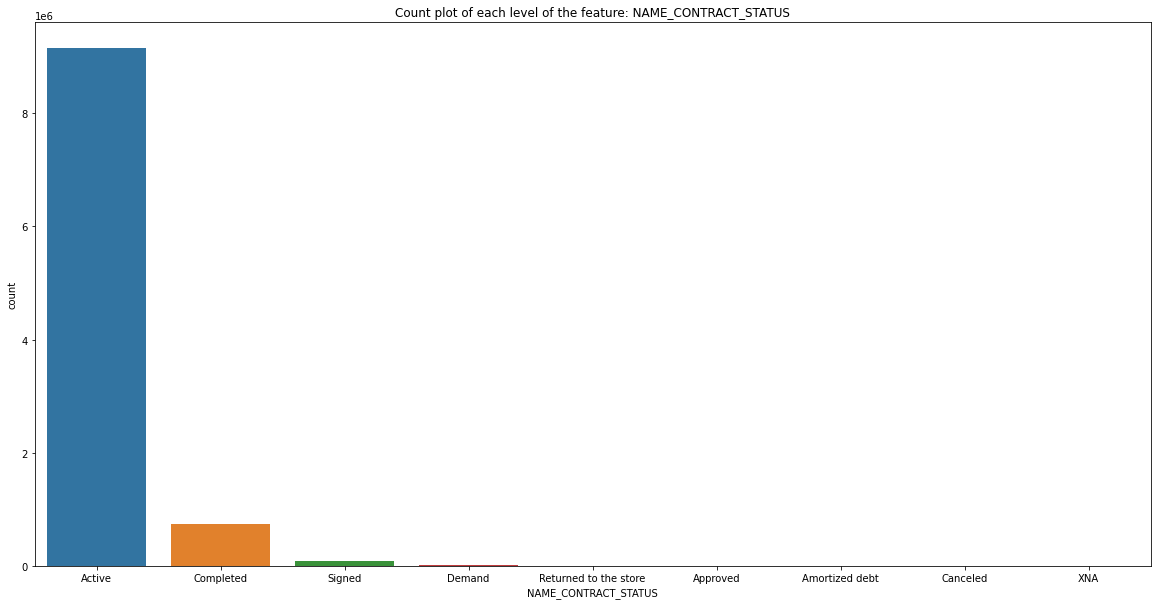

In [10]:
categorical_features_lst = Pos_Cash.select_dtypes(["object"]).columns.tolist()

for feature in categorical_features_lst:
    fig, ax = plt.subplots(1, 1, sharex = False, sharey = False, figsize = (20, 10))
    # Plot levels distribution
    if Pos_Cash[feature].nunique() < 10:
        sns.countplot(x = Pos_Cash[feature], ax = ax, order = Pos_Cash[feature].value_counts().index.tolist())
    else:
        sns.countplot(y = Pos_Cash[feature], ax = ax, order = Pos_Cash[feature].value_counts().index.tolist())
    ax.set_title("Count plot of each level of the feature: " + feature)

Text(0.5, 1.0, 'Correlation plot between numerical features')

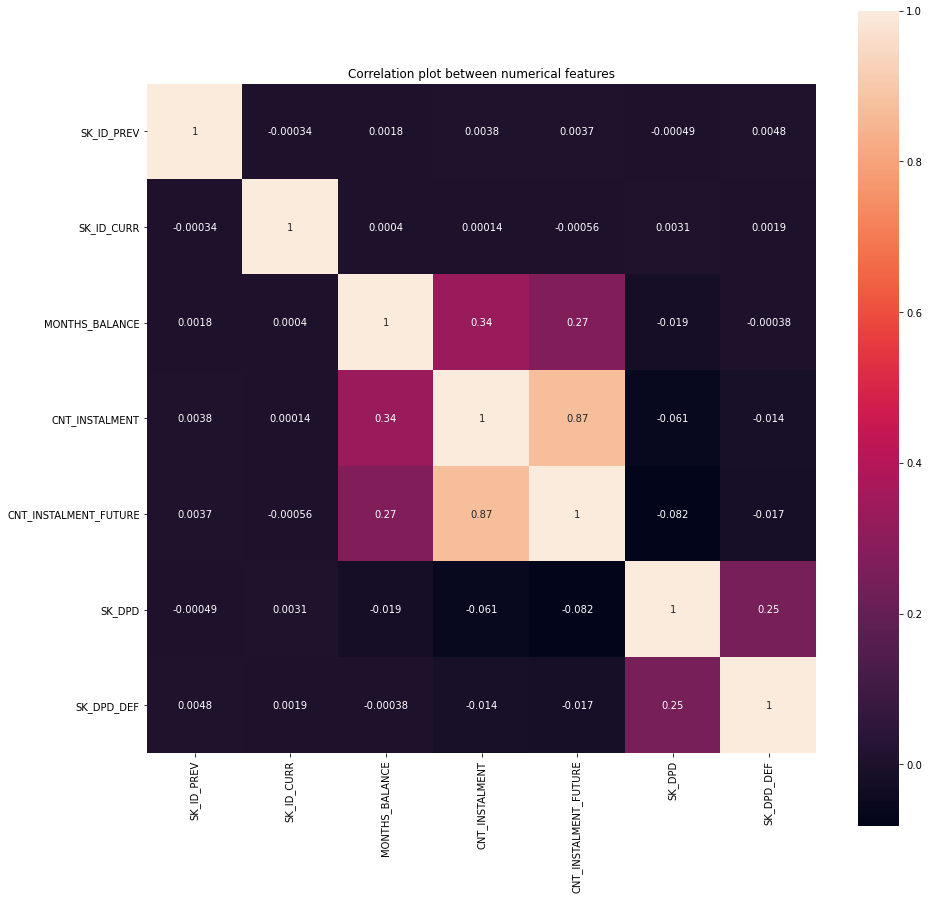

In [11]:
plt.figure(figsize = (15, 15))
sns.heatmap(Pos_Cash.corr(), annot = True, square = True)
plt.title("Correlation plot between numerical features")

We observe that CNT_INSTALMENT and CNT_INTSALMENT_FUTURE are highly correlated.

In [12]:
Pos_Cash.info(),Pos_Cash.shape,Pos_Cash.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10001358 entries, 1261679 to 3069694
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 1006.7+ MB


(None,
 (10001358, 8),
 SK_ID_PREV                   0
 SK_ID_CURR                   0
 MONTHS_BALANCE               0
 CNT_INSTALMENT           26071
 CNT_INSTALMENT_FUTURE    26087
 NAME_CONTRACT_STATUS         0
 SK_DPD                       0
 SK_DPD_DEF                   0
 dtype: int64)

In [13]:
pd.DataFrame({"No. of unique values": list(Pos_Cash.nunique())}, index=Pos_Cash.columns)

,No. of unique values
SK_ID_PREV,936325
SK_ID_CURR,337252
MONTHS_BALANCE,96
CNT_INSTALMENT,73
CNT_INSTALMENT_FUTURE,79
NAME_CONTRACT_STATUS,9
SK_DPD,3400
SK_DPD_DEF,2307


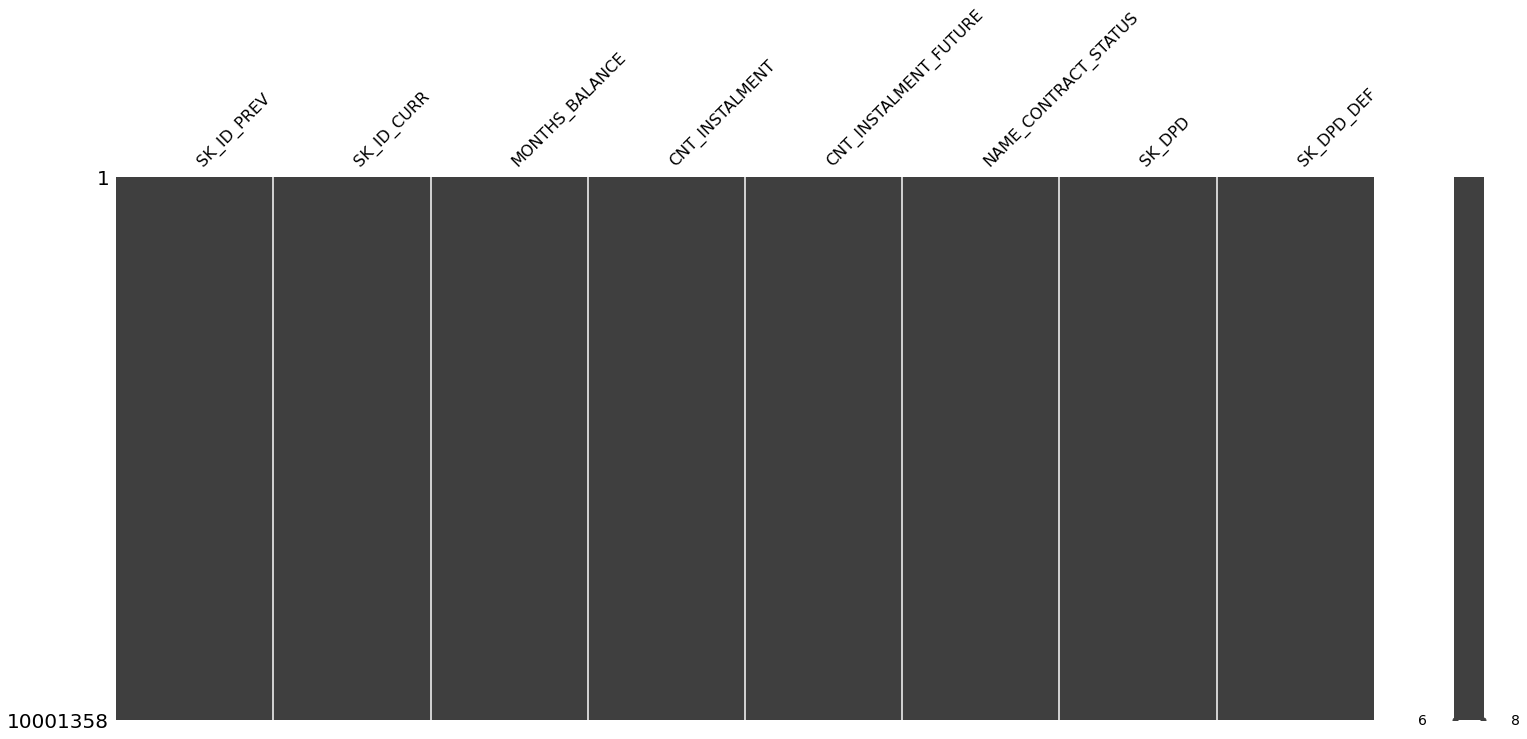

In [14]:
import missingno as msno
msno.matrix(Pos_Cash);

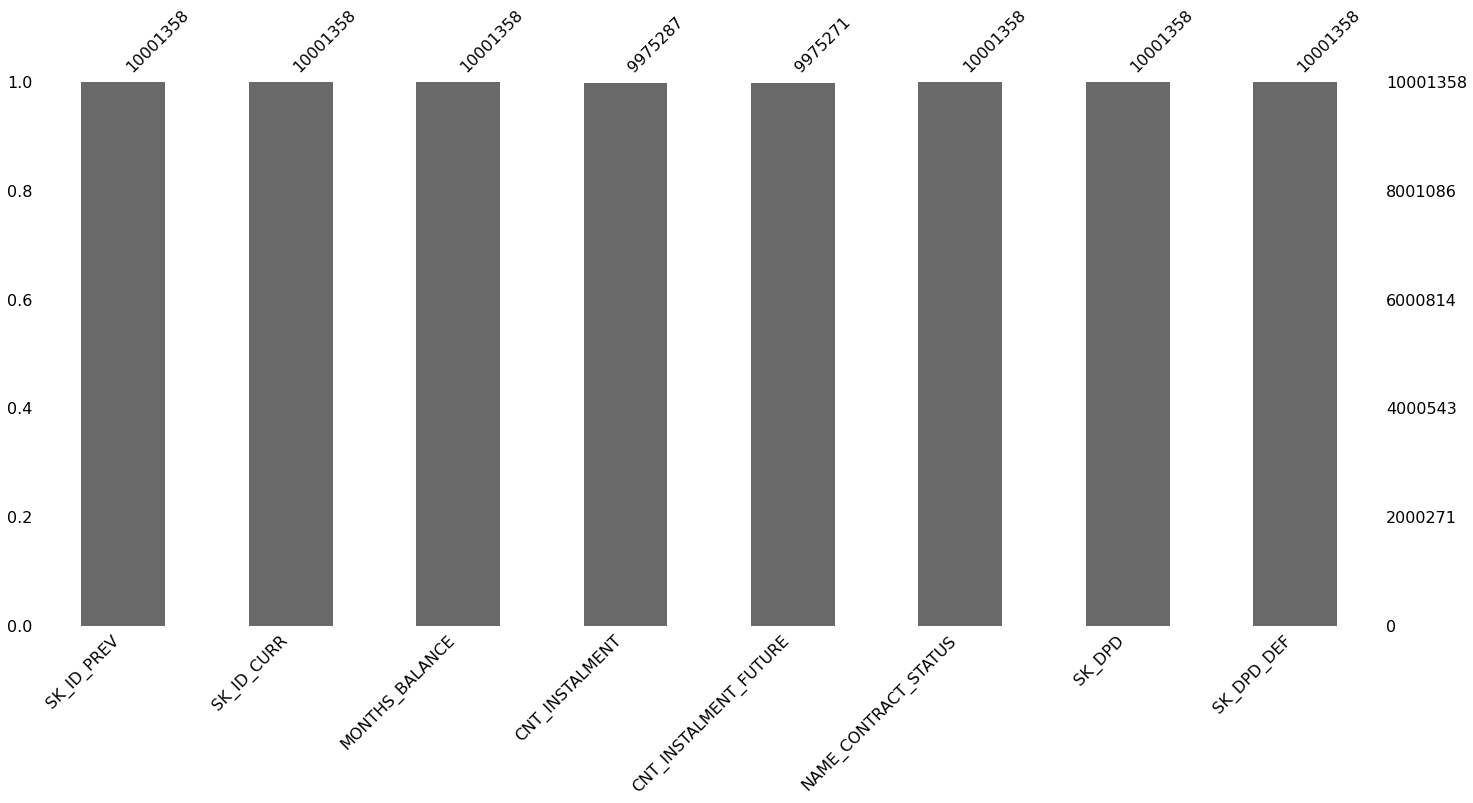

In [15]:
msno.bar(Pos_Cash);

In [16]:
missing_val = []
missing_val_rate = []
for i in Pos_Cash.columns:
    u = Pos_Cash[i].isnull().sum()
    r = (u/len(Pos_Cash)*100)
    missing_val.append(u)
    missing_val_rate.append(r)
    
y=pd.DataFrame( {"no of missing_val": missing_val,  "missing_val_rate": missing_val_rate},  index=Pos_Cash.columns)
y.sort_values("missing_val_rate", ascending=True)

,no of missing_val,missing_val_rate
SK_ID_PREV,0,0.000000
SK_ID_CURR,0,0.000000
MONTHS_BALANCE,0,0.000000
NAME_CONTRACT_STATUS,0,0.000000
SK_DPD,0,0.000000
SK_DPD_DEF,0,0.000000
CNT_INSTALMENT,26071,0.260675
CNT_INSTALMENT_FUTURE,26087,0.260835


Text(0.5, 1.0, 'Percentage of missing values in the pos cash balance data')

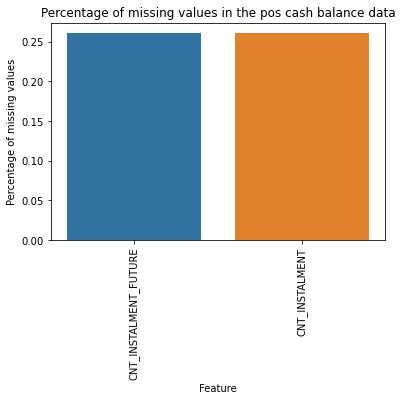

In [26]:
missing_values_sr = Pos_Cash.isnull().sum()
missing_values_df = missing_values_sr.loc[missing_values_sr > 0].sort_values(ascending = False).reset_index()
missing_values_df.columns = ["Feature", "Number of missing values"]
missing_values_df["Percentage of missing values"] = (missing_values_df["Number of missing values"] / Pos_Cash.shape[0]) * 100

sns.barplot(x = missing_values_df["Feature"], y = missing_values_df["Percentage of missing values"])
plt.xticks(rotation = 90)
plt.title("Percentage of missing values in the pos cash balance data")

Feature 1 Number of late payments within each loan (SK_ID_PREV), then it will merged with main data and groupby with "SK_ID_CURR"

In [18]:
No_Late_Payments = Pos_Cash[Pos_Cash['SK_DPD'] > 0].groupby(['SK_ID_PREV']).size().reset_index(name='Number_late_Payments') 

In [27]:
No_Late_Payments.sort_values(by=['Number_late_Payments'])

,SK_ID_PREV,Number_late_Payments
0,1000053,1
42789,1993848,1
42790,1993850,1
42791,1993853,1
42795,1993980,1
...,...,...
4009,1086645,96
9589,1218064,96
59942,2416720,96
34069,1779500,96


Feature 2 Max, mean, sum of late payments for each applicant (SK_ID_CURR), then it will merged with main data

In [28]:
LATE_PAY = Pos_Cash.groupby ('SK_ID_PREV', as_index=False)['SK_DPD'].aggregate([ 'mean', 'max', "sum"])
LATE_PAY ['SK_DPD_mean']=  LATE_PAY ['mean']
LATE_PAY ['SK_DPD_max']=  LATE_PAY ['max']
LATE_PAY ['SK_DPD_sum']=  LATE_PAY ['sum']
del LATE_PAY['mean']
del LATE_PAY['max']
del LATE_PAY['sum']
LATE_PAY

,SK_DPD_mean,SK_DPD_max,SK_DPD_sum
SK_ID_PREV,,,
1000001,0.0,0,0
1000002,0.0,0,0
1000003,0.0,0,0
1000004,0.0,0,0
1000005,0.0,0,0
...,...,...,...
2843494,0.0,0,0
2843495,0.0,0,0
2843497,0.0,0,0


In [34]:
pos_cash_lastmonth = Pos_Cash.loc[Pos_Cash.groupby('SK_ID_PREV')['MONTHS_BALANCE'].idxmax()]

In [33]:
pos_cash_lastmonth.set_index('SK_ID_CURR')
pos_cash_lastmonth

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
45995,1000001,158271,-8,2.0,0.0,Completed,0,0
2792302,1000002,101962,-50,4.0,0.0,Completed,0,0
7085917,1000003,252457,-1,12.0,9.0,Active,0,0
4078063,1000004,260094,-22,7.0,0.0,Completed,0,0
7852623,1000005,176456,-46,10.0,0.0,Completed,0,0
...,...,...,...,...,...,...,...,...
981864,2843494,292375,-24,2.0,0.0,Completed,0,0
1604188,2843495,260963,-9,7.0,0.0,Completed,0,0
1580617,2843497,451578,-1,24.0,4.0,Active,0,0
2223855,2843498,393881,-42,6.0,0.0,Completed,0,0


In [35]:
pos_cash_lastmonth[pos_cash_lastmonth["SK_ID_CURR"]==100001]

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
2197888,1369693,100001,-53,4.0,0.0,Completed,0,0
4928574,1851984,100001,-93,4.0,0.0,Completed,0,0


In [39]:
# Feature2 Dummies for "pos_name contract"
pos_cash_lastmonth = pd.get_dummies(pos_cash_lastmonth, prefix='pos_name_contract')

# Feature3 Number of previous loans (SK_ID_PREV) for each SK_ID_CURR
num_prev_loan = pos_cash_lastmonth[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
pos_cash_lastmonth['pos_prev_count'] = pos_cash_lastmonth['SK_ID_CURR'].map(num_prev_loan['SK_ID_PREV'])

In [40]:
pos_cash_lastmonth['CNT_INSTALMENT_ACTIVE']= pos_cash_lastmonth['CNT_INSTALMENT']*pos_cash_lastmonth['pos_name_contract_Active']

In [41]:
  # I merge the Feature 1 formed before, with main data ---Number of late payments within each loan (SK_ID_PREV), 
pos_cash_lastmonth = pos_cash_lastmonth.merge(No_Late_Payments, on = ['SK_ID_PREV'], how = 'left').fillna(0)

In [42]:
# I merge the Feature 2 formed before, with main data ---date of late payments for each loans: max, sum mean (SK_ID_PREV),
pos_cash_lastmonth = pos_cash_lastmonth.merge(LATE_PAY, on = ['SK_ID_PREV'], how = 'left')

In [43]:
# Feature 4 at the time of application,  for active credits, ratio of future instalments (CNT_INSTALMENT_FUTURE) to total instalment (CNT_INSTALMENT)
pos_cash_lastmonth['Ratio_future_instal_to_total_instalments'] = pos_cash_lastmonth['CNT_INSTALMENT_FUTURE']/pos_cash_lastmonth['CNT_INSTALMENT_ACTIVE']

In [44]:
pos_cash_lastmonth

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF,pos_name_contract_Active,pos_name_contract_Amortized debt,pos_name_contract_Approved,...,pos_name_contract_Demand,pos_name_contract_Returned to the store,pos_name_contract_Signed,pos_prev_count,CNT_INSTALMENT_ACTIVE,Number_late_Payments,SK_DPD_mean,SK_DPD_max,SK_DPD_sum,Ratio_future_instal_to_total_instalments
0,1000001,158271,-8,2.0,0.0,0,0,0,0,0,...,0,0,0,1,0.0,0.0,0.0,0,0,NaN
1,1000002,101962,-50,4.0,0.0,0,0,0,0,0,...,0,0,0,6,0.0,0.0,0.0,0,0,NaN
2,1000003,252457,-1,12.0,9.0,0,0,1,0,0,...,0,0,0,2,12.0,0.0,0.0,0,0,0.750000
3,1000004,260094,-22,7.0,0.0,0,0,0,0,0,...,0,0,0,9,0.0,0.0,0.0,0,0,NaN
4,1000005,176456,-46,10.0,0.0,0,0,0,0,0,...,0,0,0,1,0.0,0.0,0.0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
936320,2843494,292375,-24,2.0,0.0,0,0,0,0,0,...,0,0,0,4,0.0,0.0,0.0,0,0,NaN
936321,2843495,260963,-9,7.0,0.0,0,0,0,0,0,...,0,0,0,3,0.0,0.0,0.0,0,0,NaN
936322,2843497,451578,-1,24.0,4.0,0,0,1,0,0,...,0,0,0,9,24.0,0.0,0.0,0,0,0.166667
936323,2843498,393881,-42,6.0,0.0,0,0,0,0,0,...,0,0,0,10,0.0,0.0,0.0,0,0,NaN


In [46]:
pos_cash_final = pos_cash_lastmonth.groupby("SK_ID_CURR")
function_dict = {"MONTHS_BALANCE": "mean", 
                 "CNT_INSTALMENT": "sum", 
                 "CNT_INSTALMENT_FUTURE": "sum", 
                 "CNT_INSTALMENT_ACTIVE": "sum",
                 "Ratio_future_instal_to_total_instalments": "sum",
                 "SK_DPD": "sum", 
                 "SK_DPD_mean": "mean", 
                 "SK_DPD_max": "max", 
                 "SK_DPD_sum": "mean",
                 "Number_late_Payments": "sum", 
                 "SK_DPD_DEF": "sum",
                  "pos_name_contract_Active": "sum",
                 "pos_name_contract_Amortized debt": "sum", 
                  "pos_name_contract_Approved": "sum", 
                 "pos_name_contract_Canceled": "sum",
                  "pos_name_contract_Completed": "sum",
                 "pos_name_contract_Demand": "sum", 
                 "pos_name_contract_Returned to the store": "sum",
                 "pos_name_contract_Signed": "sum",
                  "pos_prev_count": "mean",
                  }
pos_cash_final = pos_cash_final.aggregate(function_dict)
pos_cash_final.reset_index(inplace=True)

In [47]:
pos_cash_final

,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,CNT_INSTALMENT_ACTIVE,Ratio_future_instal_to_total_instalments,SK_DPD,SK_DPD_mean,SK_DPD_max,SK_DPD_sum,...,SK_DPD_DEF,pos_name_contract_Active,pos_name_contract_Amortized debt,pos_name_contract_Approved,pos_name_contract_Canceled,pos_name_contract_Completed,pos_name_contract_Demand,pos_name_contract_Returned to the store,pos_name_contract_Signed,pos_prev_count
0,100001,-73.000000,8.0,0.0,0.0,0.000000,0,0.875000,7,3.500000,...,0,0,0,0,0,2,0,0,0,2
1,100002,-1.000000,24.0,6.0,24.0,0.250000,0,0.000000,0,0.000000,...,0,1,0,0,0,0,0,0,0,1
2,100003,-35.000000,25.0,1.0,12.0,0.083333,0,0.000000,0,0.000000,...,0,1,0,0,0,2,0,0,0,3
3,100004,-24.000000,3.0,0.0,0.0,0.000000,0,0.000000,0,0.000000,...,0,0,0,0,0,1,0,0,0,1
4,100005,-15.000000,9.0,0.0,0.0,0.000000,0,0.000000,0,0.000000,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337247,456251,-1.000000,7.0,0.0,0.0,0.000000,0,0.000000,0,0.000000,...,0,0,0,0,0,1,0,0,0,1
337248,456252,-76.000000,6.0,0.0,0.0,0.000000,0,0.000000,0,0.000000,...,0,0,0,0,0,1,0,0,0,1
337249,456253,-79.666667,22.0,0.0,6.0,0.000000,0,0.277778,5,1.666667,...,0,1,0,0,0,2,0,0,0,3
337250,456254,-1.000000,30.0,12.0,30.0,0.785714,0,0.000000,0,0.000000,...,0,2,0,0,0,0,0,0,0,2


In [ ]:
pos_cash_final.to_csv('/content/drive/MyDrive/Home Credit/home-credit-default-risk/pos_cash_final.csv')